# Mark rooftops with u-net SHARP
https://arxiv.org/pdf/2107.12461.pdf

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, Flatten, \
                         UpSampling2D, Conv2DTranspose, MaxPooling2D, \
                         Dropout, Concatenate, BatchNormalization, Activation, \
                         concatenate, DepthwiseConv2D, ReLU, Add, Conv1D, LayerNormalization, \
                         Layer, Flatten, MaxPooling1D, Activation
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import LearningRateScheduler
import h5py

from tensorflow.image import resize
import keras.backend as K

### Load data

In [3]:
X_train = np.load("data/u_net_roofs/X_data.npy")
y_train = np.load("data/u_net_roofs/y_data.npy")

X_val = np.load("data/u_net_roofs/X_data_val.npy")
y_val = np.load("data/u_net_roofs/y_data_val.npy")

X_test = np.load("data/u_net_roofs/X_data_test.npy")
y_test = np.load("data/u_net_roofs/y_data_test.npy")


In [4]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [5]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1000, 128, 128, 2)
(200, 128, 128, 2)
(500, 128, 128, 2)


In [ ]:
mymax = X_train.reshape(1000*128*128, 6).max(axis=0)
mystd = X_train.reshape(1000*128*128, 6).std(axis=0)
mymean = X_train.reshape(1000*128*128, 6).mean(axis=0)

In [ ]:
X_train = ((X_train.reshape(1000*128*128, 6) - mymean)/mystd).reshape(1000, 128, 128, 6)
X_val = ((X_val.reshape(200*128*128, 6) - mymean)/mystd).reshape(200, 128, 128, 6)
X_test = ((X_test.reshape(500*128*128, 6) - mymean)/mystd).reshape(500, 128, 128, 6)

In [ ]:
mymax = X_train.max()

X_train /= mymax
X_val /= mymax
X_test /= mymax

In [ ]:
#X[:,:,:,-1] *= 100 # Set back nDSM to orignal levels

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    yy1, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
X_train.shape

(1000, 128, 128, 6)

### Make sharp u net

In [7]:
def get_kernel():
    """
    See https://setosa.io/ev/image-kernels/
    """

    k1 = np.array([[0.0625, 0.125, 0.0625],
                   [0.125,  0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    
    k3 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    
    return k1, k2, k3


def build_sharp_blocks(layer):
    """
    Sharp Blocks
    """
    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w

In [8]:
def SharpUNet(img_size, num_classes):
    "Unet with sharp Blocks in skip connections"

    # Kernel size for sharp blocks
    kernel_size = 3

    inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_sharp_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_sharp_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_sharp_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_sharp_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])    
    
    return model

In [9]:
smooth = 1

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Show data - 5 random images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[681 680 667   8 111]


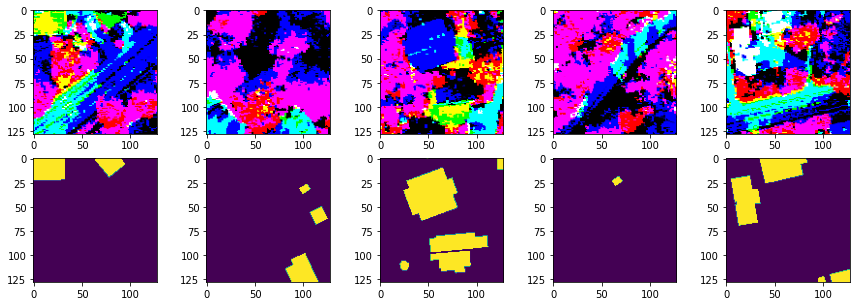

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = (15,5))

indx = np.random.randint(0,high=X_train.shape[0],size=5)
print(indx)
for i in range(5):
    #ax[0,i].imshow(np.dstack((X_train[indx[i]][:,:,76],
    #                          X_train[indx[i]][:,:,46],
    #                          X_train[indx[i]][:,:,21])))
    ax[0,i].imshow(X_train[indx[i]][:,:,0:3])
    ax[1,i].imshow(y_train[indx[i]][:,:,0])
plt.show()

### Set up u net

In [ ]:
checkpointer = ModelCheckpoint("model.h5", verbose=0, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10, mode='min', restore_best_weights=True)

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
K.clear_session()

# Build model
model = None
model = SharpUNet((128,128,6), 2)
#model.summary()

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = [jacard, dice_coef, 'accuracy'])


In [ ]:
# Train
epochs = 250
h = model.fit(X_train, y_train,
                batch_size=16,
                epochs=epochs,
                validation_data=(X_val, y_val),
                #callbacks=[early_stopping, reduce_lr, checkpointer],
                shuffle=True)

Epoch 1/250
63/63 [==============================] - 6s 63ms/step - loss: 2.0871 - jacard: 0.6889 - dice_coef: 0.8141 - accuracy: 0.8191 - val_loss: 0.6474 - val_jacard: 0.6696 - val_dice_coef: 0.8020 - val_accuracy: 0.8047
Epoch 2/250
63/63 [==============================] - 3s 54ms/step - loss: 0.3485 - jacard: 0.7006 - dice_coef: 0.8234 - accuracy: 0.8331 - val_loss: 0.4803 - val_jacard: 0.7021 - val_dice_coef: 0.8248 - val_accuracy: 0.8279
Epoch 3/250
63/63 [==============================] - 3s 54ms/step - loss: 0.2872 - jacard: 0.7395 - dice_coef: 0.8498 - accuracy: 0.8694 - val_loss: 0.4404 - val_jacard: 0.7030 - val_dice_coef: 0.8255 - val_accuracy: 0.8500
Epoch 4/250
63/63 [==============================] - 3s 53ms/step - loss: 0.2316 - jacard: 0.7789 - dice_coef: 0.8754 - accuracy: 0.9221 - val_loss: 0.3860 - val_jacard: 0.7468 - val_dice_coef: 0.8549 - val_accuracy: 0.8894
Epoch 5/250
63/63 [==============================] - 3s 54ms/step - loss: 0.1950 - jacard: 0.8057 - dice

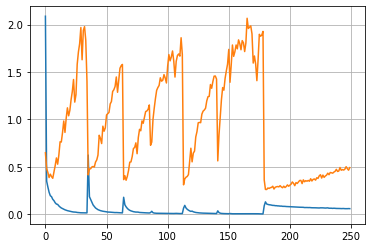

In [ ]:
plt.plot(h.history['loss'][:])
plt.plot(h.history['val_loss'][:])
plt.grid()

### Validate prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


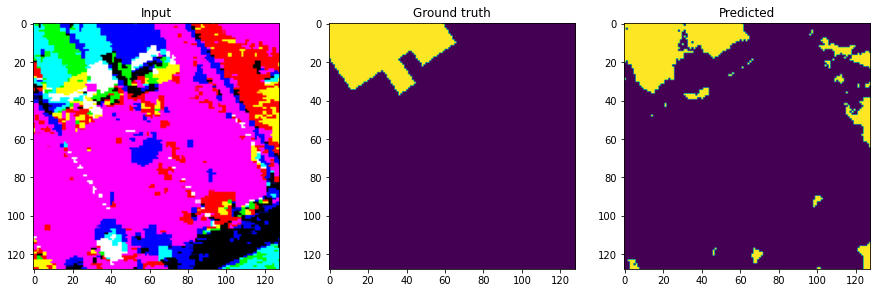

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


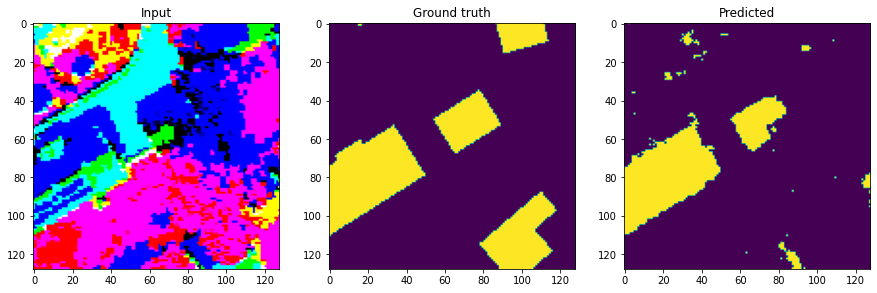

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


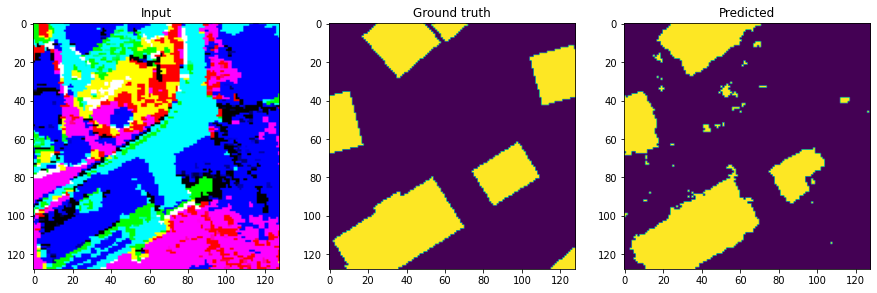

In [ ]:
for _ in range(3):
  x = np.random.randint(X_val.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_val[x:x+1][0][:,:,76],
  #                      X_val[x:x+1][0][:,:,46],
  #                      X_val[x:x+1][0][:,:,21])))
  ax1.imshow(X_val[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_val[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  pred = model.predict(X_val[x:x+1])[0].argmax(axis=2)
  ax3.imshow(pred)
  ax3.set_title("Predicted")
  plt.show()

## Test on unseen data

In [ ]:
pred = model.predict(X_test)

In [ ]:
pred.shape

(500, 128, 128, 2)

In [ ]:
from sklearn.metrics import balanced_accuracy_score

In [ ]:
print("Metrics on whole pred and useen")
print(f"f1 score: {f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")
print(f"acc score: {accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())}")

Metrics on whole pred and useen
f1 score: 0.6971882860095774
acc score: 0.9477109375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


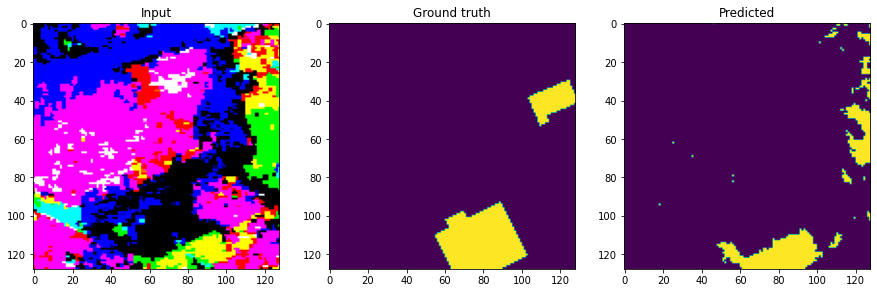

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.914794921875
f1 score: 0.43845534995977475


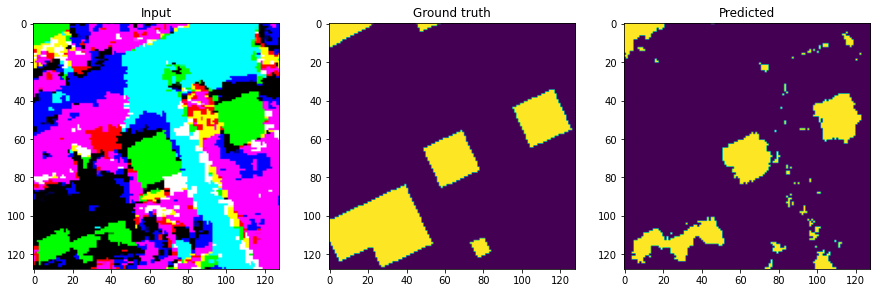

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Acc score: 0.9095458984375
f1 score: 0.6700801424755121


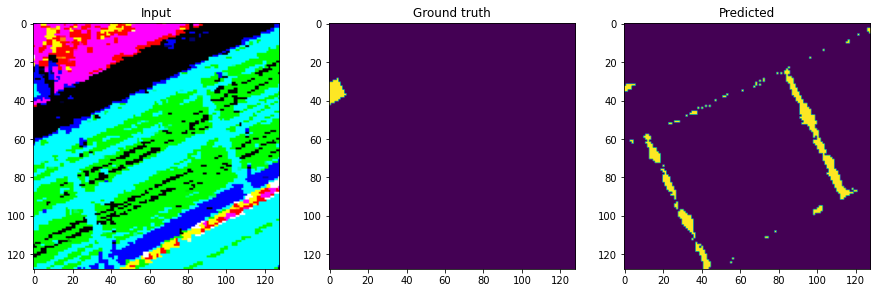

Acc score: 0.9605712890625
f1 score: 0.04437869822485207


In [ ]:
for _ in range(3):
  x = np.random.randint(pred.shape[0])
  fig, (ax1, ax2, ax3) = plt.subplots(nrows=1,ncols=3, figsize = (15,15))
  #ax1.imshow(np.dstack((X_test[x:x+1][0][:,:,76],
  #                      X_test[x:x+1][0][:,:,46],
  #                      X_test[x:x+1][0][:,:,21])))
  ax1.imshow(X_test[x:x+1][0][:,:,0:3])
  ax1.set_title("Input")
  ax2.imshow(y_test[x:x+1][0].argmax(axis=2))
  ax2.set_title("Ground truth")
  ax3.imshow(pred[x:x+1][0].argmax(axis=2))
  ax3.set_title("Predicted")
  plt.show()

  # Metrics  w threshold:
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] > .5] = 1
  pred[x:x+1,:,:,0][pred[x:x+1,:,:,0] <= .5] = 0
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] > .5] = 1
  pred[x:x+1,:,:,1][pred[x:x+1,:,:,1] <= .5] = 0

  print(f"Acc score: {accuracy_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  print(f"f1 score: {f1_score(y_test[x:x+1][0].argmax(axis=2).flatten(),\
                                     pred[x:x+1][0].argmax(axis=2).flatten())}")
  
  

In [ ]:
import seaborn as sns
sns.displot(pred[:,:,:,0])

ValueError: ignored

In [ ]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/stianteien/M_DV_V2022
   032c1eb..e07fd6c  master     -> origin/master
Updating 032c1eb..e07fd6c
Fast-forward
 roofs_w_unet/roof_u-net.ipynb | 844 ++++++++++++++++++++++++++----------------
 1 file changed, 526 insertions(+), 318 deletions(-)


# Run 5 times for testing

In [11]:
import seaborn as sns
import pandas as pd

In [14]:
epochs = 100
f1s = []
accs = []

for i in range(5):
  # Free up RAM in case the model definition cells were run multiple times
  K.clear_session()

  # Build model
  model = None
  model = SharpUNet((128,128,6), 2)
  #model.summary()

  # Compile model
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                metrics = [jacard, dice_coef, 'accuracy'])
  
  h = model.fit(X_train, y_train, 
           batch_size=16,
           epochs=epochs,
           verbose=0)

  pred = model.predict(X_test)
  f1 = f1_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())
  acc = accuracy_score(y_test.argmax(axis=3).flatten(), pred.argmax(axis=3).flatten())
  f1s.append(f1)
  accs.append(acc)

  print(f"round {i+1} of {5}, f1: {f1}, acc: {acc}")


round 1 of 5, f1: 0.7525526521876887, acc: 0.959577880859375
round 2 of 5, f1: 0.651002696616545, acc: 0.9319879150390625
round 3 of 5, f1: 0.6240287143789427, acc: 0.936706298828125
round 4 of 5, f1: 0.5895807888005871, acc: 0.926821533203125
round 5 of 5, f1: 0.5791356751281024, acc: 0.9164720458984374


In [15]:
metrics = np.array([f1s, accs])
np.save("sharpunetmetric.npy", metrics)

f1_df = pd.DataFrame(metrics.T, columns=["f1_score", "accuracy"])
f1_df

,f1_score,accuracy
0,0.752553,0.959578
1,0.651003,0.931988
2,0.624029,0.936706
3,0.589581,0.926822
4,0.579136,0.916472


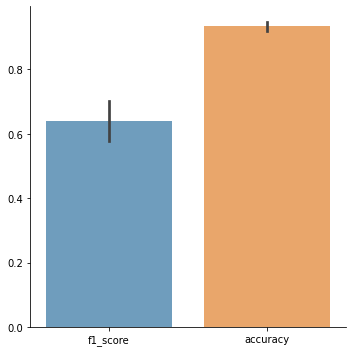

In [18]:
sns.catplot(data=f1_df,
            kind="bar",
            ci='sd',
            alpha=0.7)